In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import os
import matplotlib.pyplot as plt

In [3]:
# 1. Load data
DATA_PATH = "/kaggle/input/california-house-prices/housing.csv"
df = pd.read_csv(DATA_PATH)

In [4]:
# Quick peek
print("Dataset shape:", df.shape)
print("\nColumns and dtypes:")
print(df.dtypes)

Dataset shape: (20640, 10)

Columns and dtypes:
longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object


In [6]:
# Show first rows
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
# 2. Basic cleaning/assumptions
# Identify target column - common California housing dataset uses 'median_house_value' as target
target_col = None
for candidate in ["median_house_value", "median_house_income", "median_household_value"]:
    if candidate in df.columns:
        target_col = candidate
        break
if target_col is None:
    # If not found, assume last column is target
    target_col = df.columns[-1]

print(f"\nUsing target column: {target_col}")

# Separate features and label
X = df.drop(columns=[target_col])
y = df[target_col].copy()

# If there's an index column (like 'Unnamed: 0'), drop it
if any(col.startswith("Unnamed") for col in X.columns):
    X = X.loc[:, ~X.columns.str.startswith("Unnamed")]


Using target column: median_house_value


In [8]:
# 4. Preprocessing: detect numeric and categorical columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# Build transformers
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])


Numeric columns: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
Categorical columns: ['ocean_proximity']


In [11]:
from sklearn.model_selection import train_test_split

# Define target and features again
target_col = "median_house_value"
X = df.drop(columns=[target_col])
y = df[target_col].copy()

# Drop any unnamed index column if present
if any(col.startswith("Unnamed") for col in X.columns):
    X = X.loc[:, ~X.columns.str.startswith("Unnamed")]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Data split ready. Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

Data split ready. Shapes:
X_train: (16512, 9) y_train: (16512,)
X_test: (4128, 9) y_test: (4128,)


In [21]:
# 5. Create full pipeline with RandomForestRegressor
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

# Fit model
print("\nTraining RandomForestRegressor...")
model.fit(X_train, y_train)
print("Training finished.")


Training RandomForestRegressor...


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Training finished.


In [22]:
# 6. Evaluate
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"\nTest RMSE: {rmse:,.2f}")
print(f"Test R^2: {r2:.4f}")


Test RMSE: 48,941.70
Test R^2: 0.8172


In [23]:
# 7. Feature importances
ohe = model.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
cat_names = []
for i, cats in enumerate(ohe.categories_):
    col = categorical_cols[i]
    cat_names.extend([f"{col}__{c}" for c in cats])

all_features = numeric_cols + cat_names
importances = model.named_steps["regressor"].feature_importances_

fi_df = pd.DataFrame({
    "feature": all_features,
    "importance": importances
}).sort_values("importance", ascending=False)

print("\nTop 10 important features:\n", fi_df.head(10))


Top 10 important features:
                         feature  importance
7                 median_income    0.490642
9       ocean_proximity__INLAND    0.140925
0                     longitude    0.105889
1                      latitude    0.101597
2            housing_median_age    0.051935
5                    population    0.032573
4                total_bedrooms    0.023819
3                   total_rooms    0.023366
6                    households    0.018367
12  ocean_proximity__NEAR OCEAN    0.006336


In [24]:
# 8. Sample predictions
sample = X_test.head(5).copy()
sample["actual"] = y_test.head(5).values
sample["predicted"] = model.predict(sample.drop(columns=["actual"]))
print("\nSample predictions:\n", sample)


Sample predictions:
        longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
20046    -119.01     36.06                25.0       1505.0             NaN   
3024     -119.46     35.14                30.0       2943.0             NaN   
15663    -122.44     37.80                52.0       3830.0             NaN   
20484    -118.72     34.28                17.0       3051.0             NaN   
9814     -121.93     36.62                34.0       2351.0             NaN   

       population  households  median_income ocean_proximity    actual  \
20046      1392.0       359.0         1.6812          INLAND   47700.0   
3024       1565.0       584.0         2.5313          INLAND   45800.0   
15663      1310.0       963.0         3.4801        NEAR BAY  500001.0   
20484      1705.0       495.0         5.7376       <1H OCEAN  218600.0   
9814       1063.0       428.0         3.7250      NEAR OCEAN  278000.0   

       predicted  
20046   51744.00  
3024    71115.00  
1

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


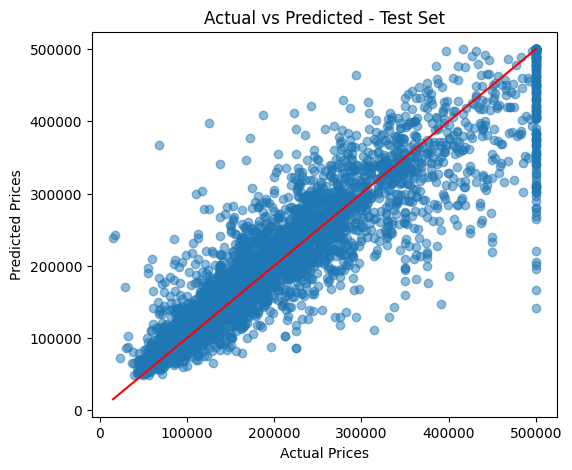

In [25]:
# 9. Scatter plot actual vs predicted
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted - Test Set")
plt.show()

In [26]:
# 10. Save trained model
MODEL_PATH = "/kaggle/working/california_model.pkl"
joblib.dump(model, MODEL_PATH)
print(f"\nModel saved to: {MODEL_PATH}")


Model saved to: /kaggle/working/california_model.pkl
